In [6]:
import os, sys
import iris
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import timeseries
import general_io as gio

In [7]:
infile_dict = {}
infile_dict['sfc-hflux-from-runoff'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/sfc-hflux-from-runoff/gn/v20191112/sfc-hflux-from-runoff-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['sfc-hflux-coupler'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/sfc-hflux-coupler/gn/v20191112/sfc-hflux-coupler-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['sfc-hflux-pme'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/sfc-hflux-pme/gn/v20191112/sfc-hflux-pme-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['frazil-3d'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/frazil-3d/gn/v20191112/frazil-3d-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['sfc-hflux-from-water-evap'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/sfc-hflux-from-water-evap/gn/v20191112/sfc-hflux-from-water-evap-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['sfc-hflux-from-water-prec'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/sfc-hflux-from-water-prec/gn/v20191112/sfc-hflux-from-water-prec-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['frazil-2d'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/frazil-2d/gn/v20191112/frazil-2d-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['masso'] = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/masso/gn/v20191112/masso_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['thetaoga'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/thetaoga/gn/v20191112/thetaoga_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['hfds'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/hfds/gn/v20191112/hfds-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['pme-mass'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/pme-mass/gn/v20191112/pme-mass-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['pme-river'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/pme-river/gn/v20191112/pme-river-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['pme-net'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/pme-net/gn/v20191112/pme-net-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['wfimelt'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/wfimelt/gn/v20191112/wfimelt-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['wfiform'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/wfiform/gn/v20191112/wfiform-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['wfo'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/wfo/gn/v20191112/wfo-gs_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'

names = {}
names['sfc-hflux-from-runoff'] = 'heat flux (relative to 0C) from liquid river runoff'
names['sfc-hflux-coupler'] = 'surface heat flux coming through coupler'
names['sfc-hflux-pme'] = 'heat flux (relative to 0C) from pme transfer of water across ocean surface'
names['frazil-3d'] = 'ocn frazil heat flux over time step'
names['sfc-hflux-from-water-evap'] = 'heat flux from evap transfer of water across ocean surface'
names['sfc-hflux-from-water-prec'] = 'heat flux from precip transfer of water across ocean surface'
names['frazil-2d'] = 'ocn frazil heat flux over time step'
names['hfds'] = 'surface_downward_heat_flux_in_sea_water'
names['pme-river'] = 'mass flux of precip-evap+river via sbc (liquid, frozen, evaporation)'
names['pme-mass'] = 'precip-evap via sbc (liquid, frozen, evaporation)'
names['pme-net'] = 'precip-evap into ocean (total w/ restore + normalize)'
names['wfimelt'] = 'water into ocean due to ice melt (>0 enters ocean)'
names['wfiform'] = 'water out of ocean due to ice form (>0 enters ocean)'
names['wfo'] = 'water_flux_into_sea_water'

In [8]:
cp = 3992.10322329649; # J kg-1 degC-1

thetaoga_cube = iris.load_cube(infile_dict['thetaoga'], 'sea_water_potential_temperature')
thetaoga_cube = gio.temperature_unit_check(thetaoga_cube, 'K')
thetaoga_cube = timeseries.convert_to_annual(thetaoga_cube, days_in_month=True)

masso_cube = iris.load_cube(infile_dict['masso'], 'sea_water_mass')
ref_time_coord = masso_cube.coord('time')
masso_cube = timeseries.convert_to_annual(masso_cube, days_in_month=True)
masso_anomaly_data = masso_cube.data - masso_cube.data[0]

ohc_data = masso_cube.data * thetaoga_cube.data * cp
ohc_anomaly_data = ohc_data - ohc_data[0]

thetaoga_anomaly_data = thetaoga_cube.data - thetaoga_cube.data[0]
thermal_data = cp * masso_cube.data[0] * thetaoga_anomaly_data

In [9]:
def read_flux(var, time_coord):
    """Read data"""
    
    infile = infile_dict[var]
    name = names[var]
    cube = iris.load_cube(infile, name)
    cube.coord('time').points = time_coord.points
    cube.coord('time').bounds = time_coord.bounds
    cube.coord('time').units = time_coord.units
    cube = timeseries.flux_to_total(cube)
    cube = timeseries.convert_to_annual(cube, aggregation='sum')
    
    return cube


def calc_cumsum(cube):
    """Calculate the cumulative sum"""
    
    cumsum_data = np.cumsum(cube.data)
    cumsum_anomaly = cumsum_data - cumsum_data[0]
    
    return cumsum_anomaly

In [10]:
cube_dict = {}
var_list = ['sfc-hflux-from-runoff', 'sfc-hflux-coupler', 'sfc-hflux-pme', 'frazil-3d',
            'hfds', 'sfc-hflux-from-water-evap', 'sfc-hflux-from-water-prec', 'frazil-2d',
            'wfo', 'pme-mass', 'pme-river', 'pme-net', 'wfimelt', 'wfiform']
for var in var_list:
    print(var)
    cube_dict[var] = read_flux(var, ref_time_coord)

sfc-hflux-from-runoff
sfc-hflux-coupler
sfc-hflux-pme
frazil-3d
hfds
sfc-hflux-from-water-evap
sfc-hflux-from-water-prec
frazil-2d
wfo
pme-mass
pme-river
pme-net
wfimelt
wfiform


In [11]:
cube_dict['ryan-hfds'] = cube_dict['sfc-hflux-from-runoff'] + cube_dict['sfc-hflux-coupler'] + \
                         cube_dict['sfc-hflux-pme'] + cube_dict['frazil-3d']

cube_dict['abhi-hfds'] = cube_dict['sfc-hflux-from-runoff'] + cube_dict['sfc-hflux-coupler'] + \
                         cube_dict['sfc-hflux-from-water-evap'] + cube_dict['sfc-hflux-from-water-prec'] + \
                         cube_dict['frazil-2d']

cube_dict['ryan-wfo'] = cube_dict['pme-mass'] + cube_dict['pme-river'] + cube_dict['pme-net'] + \
                        cube_dict['wfimelt'] + cube_dict['wfiform']

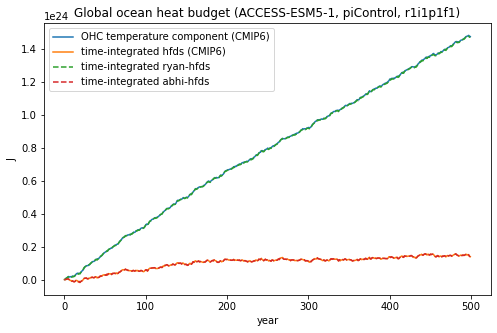

In [12]:
plt.figure(figsize=[8, 5])
plt.plot(thermal_data, label='OHC temperature component (CMIP6)')
for var in ['hfds', 'ryan-hfds', 'abhi-hfds']:
    data = calc_cumsum(cube_dict[var])
    label = var + ' (CMIP6)' if var == 'hfds' else var
    label = 'time-integrated ' + label if 'hfds' in label else label
    style = 'solid' if 'CMIP6' in label else 'dashed'
    plt.plot(data, label=label, linestyle=style)
plt.ylabel('J')
plt.xlabel('year')
plt.legend()
plt.title('Global ocean heat budget (ACCESS-ESM5-1, piControl, r1i1p1f1)')
plt.savefig('/g/data/r87/dbi599/temp/access_heat_budget_closure.png', dpi=300)

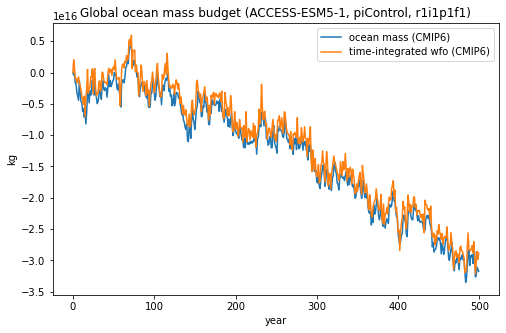

In [13]:
plt.figure(figsize=[8, 5])
plt.plot(masso_anomaly_data, label='ocean mass (CMIP6)')
for var in ['wfo']:
    data = calc_cumsum(cube_dict[var])
    label = var + ' (CMIP6)' if var == 'wfo' else var
    label = 'time-integrated ' + label if 'wfo' in label else label
    style = 'solid' if 'CMIP6' in label else 'dashed'
    plt.plot(data, label=label, linestyle=style)
plt.ylabel('kg')
plt.xlabel('year')
plt.legend()
plt.title('Global ocean mass budget (ACCESS-ESM5-1, piControl, r1i1p1f1)')
plt.savefig('/g/data/r87/dbi599/temp/access_mass_budget_closure.png', dpi=300)

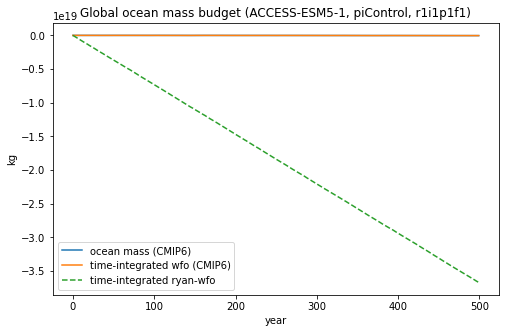

In [14]:
plt.figure(figsize=[8, 5])
plt.plot(masso_anomaly_data, label='ocean mass (CMIP6)')
for var in ['wfo', 'ryan-wfo']:
    data = calc_cumsum(cube_dict[var])
    label = var + ' (CMIP6)' if var == 'wfo' else var
    label = 'time-integrated ' + label if 'wfo' in label else label
    style = 'solid' if 'CMIP6' in label else 'dashed'
    plt.plot(data, label=label, linestyle=style)
plt.ylabel('kg')
plt.xlabel('year')
plt.legend()
plt.title('Global ocean mass budget (ACCESS-ESM5-1, piControl, r1i1p1f1)')
plt.show()

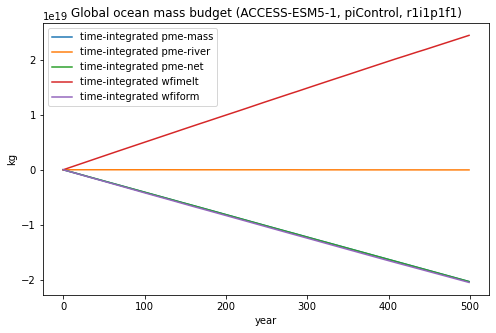

In [15]:
plt.figure(figsize=[8, 5])
for var in ['pme-mass', 'pme-river', 'pme-net', 'wfimelt', 'wfiform']:
    data = calc_cumsum(cube_dict[var])
    label = f'time-integrated {var}'
    plt.plot(data, label=label)
plt.ylabel('kg')
plt.xlabel('year')
plt.legend()
plt.title('Global ocean mass budget (ACCESS-ESM5-1, piControl, r1i1p1f1)')
plt.show()


